# Simulations

In [392]:
import os
import pandas as pd
import sys
from eks.utils import *
from eks.multiview_pca_smoother import *
from eks.newton_eks import *
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm
from scipy.optimize import *
import scipy as sp

$x_0 \sim N(\mu_0, \Sigma_0)$ and $x_t = A x_{t-1}+n_t$ with $n_t \sim N(0,E)$ and $y_t = B x_t + e_t$ with $e_t \sim N(0,D_t)$

In [393]:
def sample_fixed_variance(m0, S0, A, Q, C, R, num_points):
    
    x = np.random.multivariate_normal(mean=m0, cov=S0)
    y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
    
    x_ = np.array([x])
    y_ = np.array([y])
    
    for i in range(num_points - 1):
        
        x = np.random.multivariate_normal(mean=np.dot(A, x), cov=Q)
        y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
        
        x_ = np.concatenate([x_[:], x[None, :]], axis=0)
        y_ = np.concatenate([y_[:], y[None, :]], axis=0)
    
    return x_, y_

In [576]:
pupil_diameters = 18
v_x = 2
v_y = 10
v_d = 0.1
n = 8
r = 3
T = 100
m0 = np.asarray([pupil_diameters, 0.0, 0.0])

# diagonal: var
S0 = np.asarray([
    [v_d, 0.0, 0.0],
    [0.0, v_x, 0.0],
    [0.0, 0.0, v_y]
])

A = np.asarray([
    [0.99, 0, 0],
    [0, 0.99, 0],
    [0, 0, 0.99]
])
B = np.asarray([[0, 1, 0], [-.5, 0, 1], [0, 1, 0], 
                [.5, 0, 1], [.5, 1, 0], [0, 0, 1], 
                [-.5, 1, 0],[0, 0, 1]])

# state covariance matrix
E = np.asarray([
        [v_d * (1 - (A[0, 0] ** 2)), 0, 0],
        [0, v_x * (1 - A[1, 1] ** 2), 0],
        [0, 0, v_y * (1 - (A[2, 2] ** 2))]
    ])
D = np.eye(n)

np.random.seed(123)
u = np.random.uniform(10,20,n)
ensemble_vars =  np.random.multivariate_normal(u, np.eye(n), T).T
print(ensemble_vars.shape)

(8, 100)


In [572]:
def sample_trajectory(m0, S0, A, E, B, ensemble_vars):
    T = ensemble_vars.shape[1]
    r = m0.shape[0]
    n = ensemble_vars.shape[0]
    x = np.zeros((r,T))
    y = np.zeros((n,T))
    x[:,0] = np.random.multivariate_normal(mean=m0, cov=S0)
    for i in range(1,T):
        D = np.diag(ensemble_vars[:,i])
        
        x[:,i] = np.random.multivariate_normal(mean=A@x[:,i-1], cov=E)
        y[:,i] = np.random.multivariate_normal(mean=B@x[:,i], cov=D)
        
    return x.T, y.T

In [573]:
q, y = sample_trajectory(m0, S0, A, E, B, ensemble_vars)

In [619]:
pupil_diameters = 18
v_x = 2
v_y = 10
v_d = 0.1
n = 3
r = 2
T = 100
m0 = np.asarray([0.0])

# diagonal: var
S0 = np.asarray([1])

A = np.asarray([0.99, 0.0],
               [0.0, 0.99])
                
B = np.asarray([[0, 1], [-.5, 0], [0, 1]])


# state covariance matrix
E = np.asarray([2])
D = np.eye(n)

np.random.seed(123)
u = np.random.uniform(10,20,n)
ensemble_vars =  np.random.multivariate_normal(u, np.eye(n), T).T
print(ensemble_vars.shape)



def sample_1d(m0, S0, A, E, B, D, T):
    
    x = np.random.normal(m0, S0)
    y = np.random.multivariate_normal(mean=B@x, cov=D)
    
    x_ = np.array([x])
    y_ = np.array([y])
    
    for i in range(T - 1):
        
        x = np.random.normal(A*x, E)
        y = np.random.multivariate_normal(mean=B@x, cov=D)
        
        x_ = np.concatenate([x_[:], x[None, :]], axis=0)
        y_ = np.concatenate([y_[:], y[None, :]], axis=0)
    
    return x_, y_

TypeError: Field elements must be 2- or 3-tuples, got '0.0'

In [597]:
q, y = sample_1d(m0, S0, A, E, B, D, T)

In [598]:
y.shape

(100, 3)

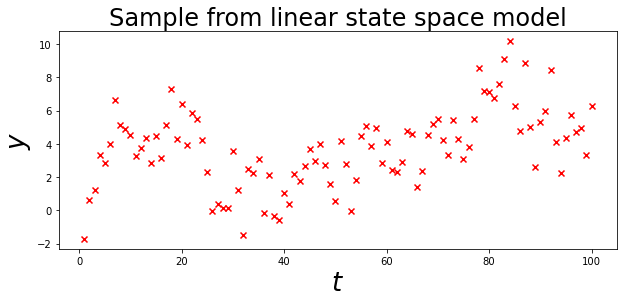

In [599]:
# Plot sampled data
plt.figure(figsize=(10, 4))


plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.title('Sample from linear state space model', fontsize=24)

plt.scatter(np.arange(1, T + 1), y[:,1], marker='x', color='red', zorder=3)
#plt.scatter(np.arange(1, T + 1), y[:, 2], marker='x', color='blue', zorder=3)
#plt.scatter(np.arange(1, T + 1), y[:, 4], marker='x', color='grey', zorder=3)
plt.show()



## Standard eks solve

In [618]:
# Do the filtering step
mf, Vf, S = filtering_pass(y, m0.reshape((1,1)), S0.reshape((1,1)), B.reshape((3,1)), D.reshape((3,3)), A.reshape((1,1)), E.reshape((1,1)), ensemble_vars.T)

# Do the smoothing step
ms, Vs, _ = smooth_backward(y, mf, Vf, S, A, E, B)




for i in [1,2,6]:
    # Smoothed posterior over y
    y_m_smooth = np.dot(B, ms.T)[i,:]

    # Plot results
    plt.figure(figsize=(10, 4))

    # Plot the observed data y
    plt.scatter(np.arange(1, T + 1),
                y[:, i],
                marker='x',
                color='red',
                zorder=3, 
                label='Observations')
    plt.plot(y_m_smooth)

plt.title('Smoothed posterior', fontsize=26)


plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.legend()

plt.show()

ValueError: could not broadcast input array from shape (3,) into shape (1,)

## Optimisation eks solve


In [601]:
# Do the filtering step
q, loss = kalman_newton_recursive(y, m0, S0, A, B, ensemble_vars.T,E, max_iter=10)


for i in [1,2,6]:
    # Smoothed posterior over y
    y_m_smooth = np.dot(B, ms.T)[i,:]
    y_m_opti = np.dot(B, q.T)[i,:]
    # Plot results
    plt.figure(figsize=(10, 4))

    # Plot the observed data y
    plt.scatter(np.arange(1, T + 1),
                y[:, i],
                marker='x',
                color='red',
                zorder=3, 
                label='Observations')
    plt.plot(y_m_smooth, 'b-.')
    plt.plot(y_m_opti, 'g--')

plt.title('Smoothed posterior', fontsize=26)


plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.legend()

plt.show()

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [602]:
T = y.shape[0]
r = S0.shape[0]
n = y.shape[1]

D = np.diag(ensemble_vars[:,0])

for i in range(1,ensemble_vars.shape[1]-1):
    D = np.diag(ensemble_vars[:,i])

In [603]:
def Hessian_tridiag(y, S0, A, B, E, ensemble_vars):
    T = y.shape[0]
    r = S0.shape[0]
    n = y.shape[1]
    H = np.zeros((r*T,r*T))
    invE = np.linalg.inv(E)

    D = np.diag(ensemble_vars[:,0])
    invD = np.linalg.inv(D)
    H[:r,:r] = B.T@invD@B + np.linalg.inv(S0)+A.T@invE@A

    for i in range(T-1):
        D = np.diag(ensemble_vars[:,i])
        invD = np.linalg.inv(D)
        H[i*r:(i+1)*r,i*r:(i+1)*r] = B.T@invD@B + invE +A.T@invE@A
        H[i*r:(i+1)*r, (i+1)*r:(i+2)*r] = - A.T@invE
        H[(i+1)*r:(i+2)*r, i*r:(i+1)*r] = - A.T@invE
    H[r*(T-1):r*T,r*(T-1):r*T] = invE
    return H

In [604]:
H = Hessian_tridiag(y, S0, A, B, E, ensemble_vars)
sns.heatmap(H[T-20*r:T,T-20*r:T])

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [605]:
def gradient_tridiag(q, y, m0, S0, A, B, E, ensemble_vars):
    r = m0.shape[0]
    T = y.shape[0]
    G = np.zeros((r,T))
    invE = np.linalg.inv(E)
    D = np.diag(ensemble_vars[:,0])
    invD = np.linalg.inv(D)
    G[:,0] = - B.T @ invD @ (y[0,:] - B@q[0,:]) - A.T @ invE @ (q[1, :]-A@q[0,:]) + np.linalg.inv(S0)@(q[0,:]-m0)
    for i in range(T-1):
        D = np.diag(ensemble_vars[:,i])
        invD = np.linalg.inv(D)
        G[:,i] = - B.T @ invD@(y[i,:] - B@q[i,:]) - A.T @ invE @(q[i+1,:]-A@q[i,:]) + invE@(q[i,:]-A@q[i-1,:])
    G[:,T-1] = - B.T @ invD@(y[T-1,:] - B@q[T-1,:])+ invE@(q[T-1,:]-A@q[T-2,:])
    return G

In [606]:
def Block_thomas_algo(x, y, m0, S0, A, B, E, ensemble_vars):
    D = ensemble_vars[:,0]
    M = np.zeros((r,r))
    M = np.linalg.inv(S0) + A.T @ invE @ A 
    invM = np.linalg.inv(M)
    Tr = np.zeros((T,r,r)) 
    q = np.zeros((T,r))
    s = np.zeros((T,r))
    Tr[0,:] = invM@ A.T @ invE
    G = gradient_tridiag(x, y, m0, S0, A, B, E, ensemble_vars)
    q[0,:] = - invM @ G[:,0]
    for t in range(1,T):
        D = np.diag(ensemble_vars[:,t])
        invD = np.linalg.inv(D)
        M = invE + A.T @ invE @ A + B.T @ invD @ B - A.T@invE@invM@(A.T @ invE).T
        invM = np.linalg.inv(M)   
        Tr[t,:] = invM @ A.T @ invE
        q[t,:] = - invM @( G[:,t] - (A.T@invE).T @q[t-1,:] )
    s[T-1,:] = q[T-1,:]
    for t in range(T-2, -1, -1):
        s[t,:] = q[t,:] + Tr[t,:]@s[t+1,:]
        
    return s

    

In [607]:
def newton_tridiag(y, m0, S0, A, B, E, ensemble_vars, max_iter = 200, eps= 10e-1):
    # initialisation
    
    r = m0.shape[0]
    T = y.shape[0]
    n = y.shape[1]
    loss = np.zeros(max_iter)
    q = np.zeros((T,r))
    
    for iter in range(max_iter):
        s = Block_thomas_algo(q, y, m0, S0, A, B, E, ensemble_vars)
        loss[iter] = np.linalg.norm(s)
        q += s 
        if np.linalg.norm(s) < eps:
            return q
    
    return q
    
    
    
    
    

In [608]:
q_newton = newton_tridiag(y, m0, S0, A, B, E, ensemble_vars, max_iter=1)    

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [609]:
q2 = kalman_newton_recursive(y, m0, S0, A, B, ensemble_vars.T,E)
#q_newton = Block_thomas_algo(y, m0, S0, A, B, E, ensemble_vars)

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [610]:

for i in [1,2,6]:
    # Smoothed posterior over y
    y_m_smooth = np.dot(B, ms.T)[i,:]
    y_m_opti2 = np.dot(B, q2.T)[i,:]
    y_m_opti = np.dot(B, q_newton.T)[i,:]
    # Plot results
    plt.figure(figsize=(10, 4))

    # Plot the observed data y
  #  plt.scatter(np.arange(1, T + 1), y[:, i],marker='x',color='red', zorder=3, label='Observations')
    plt.plot(y_m_smooth, 'b-.', label='standard eks')
    plt.plot(y_m_opti, 'g--', label='blocktridiag')
    plt.plot(y_m_opti2, 'r--',label='recursive')

plt.title('Smoothed posterior', fontsize=26)


plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.legend()

plt.show()

ValueError: shapes (3,1) and (3,100) not aligned: 1 (dim 1) != 3 (dim 0)

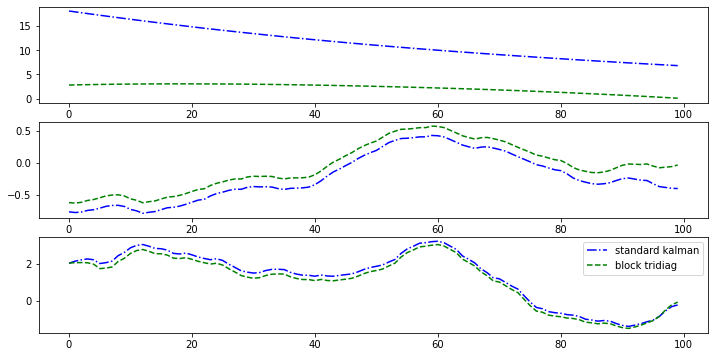

In [612]:

fig,ax = plt.subplots(nrows=3,ncols=1, figsize=(12,6))
for i in range(3):
    ax[i].plot(ms[:,i], 'b-.', label="standard kalman")
    ax[i].plot(q_newton[:,i], 'g--', label="block tridiag")
    #ax[i].plot(q2[:,i], 'r--', label="recursive newton")
plt.legend()